In [90]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np



    Розарпаковка архіву. Переведення даних з файлів .csv у словник датасетів. 

In [91]:
zip_file_path = 'homework.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

data_folder = 'data'

subdirectories = [subdir for subdir in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, subdir))]
print(subdirectories)
dataframes = {}

for subdir in subdirectories:
    subdir_path = os.path.join(data_folder, subdir)
    files = os.listdir(subdir_path)

    df = pd.DataFrame()

    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(subdir_path, file)
            data = pd.read_csv(file_path)
            df = pd.concat([df, data], ignore_index=True)

    dataframes[subdir] = df

for subdir, df in dataframes.items():
    print(f"Dataframe для {subdir}:")
    print(df.head())

['running', 'idle', 'stairs', 'walking']
Dataframe для running:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0        -2.983175        10.347740         1.575385
1        -4.070143        -5.482722        -6.818686
2         0.081403         9.404425        -3.203442
3         3.806781         7.503428         1.221043
4        -9.988609        -5.995081        -5.080496
Dataframe для idle:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0         0.186748        -0.043096         9.744401
1         0.325611         0.023942         9.773131
2         0.215478        -0.023942         9.725247
3         0.272939        -0.110133         9.777920
4         0.263362        -0.105345         9.801862
Dataframe для stairs:
   accelerometer_X  accelerometer_Y  accelerometer_Z
0         5.923255       -18.195932        10.486604
1         2.595315        -7.762002       -10.606314
2        -6.287173       -20.609290       -38.086960
3         1.498770       -14.719552        -5.

    Додавання до кожного датасету стовпця, що відповідає дії: 0 - 'running', 1 - 'idle', 2 - 'stairs', 3 - 'walking'.
    Обєднання всіх датасетів у один датафрейм

In [92]:
scaler = StandardScaler()


for index, (subdir, df) in enumerate(dataframes.items()):
    df['Action'] = index
    dataframes[subdir] = df

merged_df = pd.concat(dataframes.values(), ignore_index=True)
print(merged_df)

        accelerometer_X  accelerometer_Y  accelerometer_Z  Action
0             -2.983175        10.347740         1.575385       0
1             -4.070143        -5.482722        -6.818686       0
2              0.081403         9.404425        -3.203442       0
3              3.806781         7.503428         1.221043       0
4             -9.988609        -5.995081        -5.080496       0
...                 ...              ...              ...     ...
193855        -2.365471       -13.239936        -1.675941       3
193856        -2.820370        -3.457227        -0.967257       3
193857        -1.192312        -8.413225         0.512359       3
193858        -2.820370        -2.643199        -0.478840       3
193859        -0.316035        -8.657434        -0.531513       3

[193860 rows x 4 columns]


    Нормалізація за допомогою StandardScaler

In [93]:

scaler = StandardScaler()

# Нормалізуємо дані, крім стовпця "Action"
normalized_data = merged_df.drop(columns=['Action'])
normalized_data = scaler.fit_transform(normalized_data)

# Створюємо DataFrame з нормалізованими даними
normalized_df = pd.DataFrame(normalized_data, columns=merged_df.columns[:-1])  # без стовпця "Action"

# Додаємо стовпець "Action" зі списку
normalized_df['Action'] = merged_df['Action']

print(normalized_df)


        accelerometer_X  accelerometer_Y  accelerometer_Z  Action
0             -0.583797         0.701410        -0.031914       0
1             -0.713123        -0.567666        -1.199123       0
2             -0.219177         0.625788        -0.696418       0
3              0.224065         0.473391        -0.081186       0
4             -1.417297        -0.608740        -0.957425       0
...                 ...              ...              ...     ...
193855        -0.510303        -1.189536        -0.484016       3
193856        -0.564427        -0.405288        -0.385472       3
193857        -0.370722        -0.802594        -0.179729       3
193858        -0.564427        -0.340030        -0.317557       3
193859        -0.266464        -0.822172        -0.324882       3

[193860 rows x 4 columns]


    Визначення списку індексів для початкових індексів кожного сегмента.
    Поділ даних на сегменти та розрахнок часових ознак для кожного сегмента.
    Створенння нового датафрейму, який містить часові ознаки для кожного сегмента разом з відповідними мітками класів.

In [94]:
# Крок переміщення між сегментами (50% перекриття)
segment_size = 208
step_size = int(segment_size / 2)

# Створення списку індексів для початкових індексів кожного сегмента
start_indexes = list(range(0, len(normalized_df), step_size))

In [95]:
# Список для збереження часових ознак для кожного сегмента
time_domain_features = []

# Проходимося по кожному початковому індексу кожного сегмента
for start_index in start_indexes:
    # Визначаємо кінець поточного сегмента
    end_index = start_index + segment_size
    # Вибираємо дані для поточного сегмента
    segment_data = normalized_df.iloc[start_index:end_index, :-1]  # без стовпця "Action"

    # Розраховуємо часові ознаки для поточного сегмента
    segment_features = {
        'mean_x': segment_data['accelerometer_X'].mean(),
        'mean_y': segment_data['accelerometer_Y'].mean(),
        'mean_z': segment_data['accelerometer_Z'].mean(),
        'std_x': segment_data['accelerometer_X'].std(),
        'std_y': segment_data['accelerometer_Y'].std(),
        'std_z': segment_data['accelerometer_Z'].std(),
        'min_x': segment_data['accelerometer_X'].min(),
        'min_y': segment_data['accelerometer_Y'].min(),
        'min_z': segment_data['accelerometer_Z'].min(),
        'max_x': segment_data['accelerometer_X'].max(),
        'max_y': segment_data['accelerometer_Y'].max(),
        'max_z': segment_data['accelerometer_Z'].max(),
        'median_x': segment_data['accelerometer_X'].median(),
        'median_y': segment_data['accelerometer_Y'].median(),
        'median_z': segment_data['accelerometer_Z'].median(),
        '25th_percentile_x': segment_data['accelerometer_X'].quantile(0.25),
        '25th_percentile_y': segment_data['accelerometer_Y'].quantile(0.25),
        '25th_percentile_z': segment_data['accelerometer_Z'].quantile(0.25),
        '75th_percentile_x': segment_data['accelerometer_X'].quantile(0.75),
        '75th_percentile_y': segment_data['accelerometer_Y'].quantile(0.75),
        '75th_percentile_z': segment_data['accelerometer_Z'].quantile(0.75),
        'rms_x': np.sqrt(np.mean(segment_data['accelerometer_X'] ** 2)),
        'rms_y': np.sqrt(np.mean(segment_data['accelerometer_Y'] ** 2)),
        'rms_z': np.sqrt(np.mean(segment_data['accelerometer_Z'] ** 2)),
        'mean': np.mean([segment_data['accelerometer_X'].mean(),
                         segment_data['accelerometer_Y'].mean(),
                         segment_data['accelerometer_Z'].mean()]),
        'std': np.mean([segment_data['accelerometer_X'].std(),
                        segment_data['accelerometer_Y'].std(),
                        segment_data['accelerometer_Z'].std()]),
        'min': np.mean([segment_data['accelerometer_X'].min(),
                        segment_data['accelerometer_Y'].min(),
                        segment_data['accelerometer_Z'].min()]),
        'max': np.mean([segment_data['accelerometer_X'].max(),
                        segment_data['accelerometer_Y'].max(),
                        segment_data['accelerometer_Z'].max()]),
        'median': np.mean([segment_data['accelerometer_X'].median(),
                           segment_data['accelerometer_Y'].median(),
                           segment_data['accelerometer_Z'].median()]),
        '25th_percentile': np.mean([segment_data['accelerometer_X'].quantile(0.25),
                                    segment_data['accelerometer_Y'].quantile(0.25),
                                    segment_data['accelerometer_Z'].quantile(0.25)]),
        '75th_percentile': np.mean([segment_data['accelerometer_X'].quantile(0.75),
                                    segment_data['accelerometer_Y'].quantile(0.75),
                                    segment_data['accelerometer_Z'].quantile(0.75)]),
        'rms': np.mean([np.sqrt(np.mean(segment_data['accelerometer_X'] ** 2)),
                        np.sqrt(np.mean(segment_data['accelerometer_Y'] ** 2)),
                        np.sqrt(np.mean(segment_data['accelerometer_Z'] ** 2))])
    }

    # Додаємо часові ознаки до списку
    time_domain_features.append(segment_features)

# Створюємо DataFrame з часовими ознаками
time_domain_df = pd.DataFrame(time_domain_features)

# Додаємо стовпець "Action" зі списку індексів
time_domain_df['Action'] = normalized_df['Action'].iloc[::step_size].values

print(time_domain_df.head())


     mean_x    mean_y    mean_z     std_x     std_y     std_z     min_x  \
0  0.258703  0.452324  0.027589  1.116132  0.953011  1.083355 -3.138419   
1  0.551210  0.503590 -0.010316  1.103953  0.962263  1.078645 -1.354627   
2  0.611951  0.614713 -0.057033  1.135218  0.958601  0.955942 -1.354627   
3  0.591928  0.582062 -0.048678  1.130616  0.997452  0.987720 -1.066919   
4  0.549523  0.559884 -0.071938  1.191009  1.085022  0.998333 -1.458886   

      min_y     min_z     max_x  ...     rms_z      mean       std       min  \
0 -1.488955 -2.576071  4.257108  ...  1.081100  0.246205  1.050833 -2.401148   
1 -1.595287 -2.032084  4.327184  ...  1.076098  0.348161  1.048287 -1.660666   
2 -1.595287 -2.032084  4.433721  ...  0.955345  0.389877  1.016587 -1.660666   
3 -2.922327 -2.869039  4.433721  ...  0.986545  0.375104  1.038596 -2.286095   
4 -2.922327 -2.869039  4.433721  ...  0.998525  0.345823  1.091455 -2.416751   

        max    median  25th_percentile  75th_percentile       rms  A

In [96]:
time_domain_df.head(1)

,mean_x,mean_y,mean_z,std_x,std_y,std_z,min_x,min_y,min_z,max_x,...,rms_z,mean,std,min,max,median,25th_percentile,75th_percentile,rms,Action
0,0.258703,0.452324,0.027589,1.116132,0.953011,1.083355,-3.138419,-1.488955,-2.576071,4.257108,...,1.0811,0.246205,1.050833,-2.401148,3.875386,0.166816,-0.45549,0.793155,1.092347,0


    Розділення датасету на навчальний і тестовий.

In [97]:
from sklearn.model_selection import train_test_split

X = time_domain_df.drop(columns=['Action'])
y = time_domain_df['Action']
# Розділення даних у співвідношенні 80% для навчання та 20% для тестування
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Розмірність навчального датасету:", X_train.shape, y_train.shape)
print("Розмірність тестового датасету:", X_test.shape, y_test.shape)


Розмірність навчального датасету: (1492, 32) (1492,)
Розмірність тестового датасету: (373, 32) (373,)


In [98]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Ініціалізуємо класифікатор SVM
svm_classifier = SVC()

# Навчаємо модель SVM на навчальних даних
svm_classifier.fit(X_train, y_train)

# Передбачення за допомогою моделі SVM на тестових даних
svm_predictions = svm_classifier.predict(X_test)

# Оцінка точності моделі SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("Точність моделі SVM:", svm_accuracy)

# Ініціалізуємо класифікатор випадкового лісу
rf_classifier = RandomForestClassifier()

# Навчаємо модель випадкового лісу на навчальних даних
rf_classifier.fit(X_train, y_train)

# Передбачення за допомогою моделі випадкового лісу на тестових даних
rf_predictions = rf_classifier.predict(X_test)

# Оцінка точності моделі випадкового лісу
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Точність моделі випадкового лісу:", rf_accuracy)


Точність моделі SVM: 1.0
Точність моделі випадкового лісу: 1.0


In [99]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Навчання моделі SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Передбачення класів для тестового датасету з використанням моделі SVM
svm_predictions = svm_model.predict(X_test)

# Навчання моделі випадкового лісу
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Передбачення класів для тестового датасету з використанням моделі випадкового лісу
rf_predictions = rf_model.predict(X_test)

# Виведення classification report для моделі SVM
print("Classification Report для моделі SVM:")
print(classification_report(y_test, svm_predictions))

# Виведення classification report для моделі випадкового лісу
print("Classification Report для моделі випадкового лісу:")
print(classification_report(y_test, rf_predictions))


Classification Report для моделі SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00       101

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373

Classification Report для моделі випадкового лісу:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00       101

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



    Далі - узагальнююча серія графіків для попередньої оцінки розділення

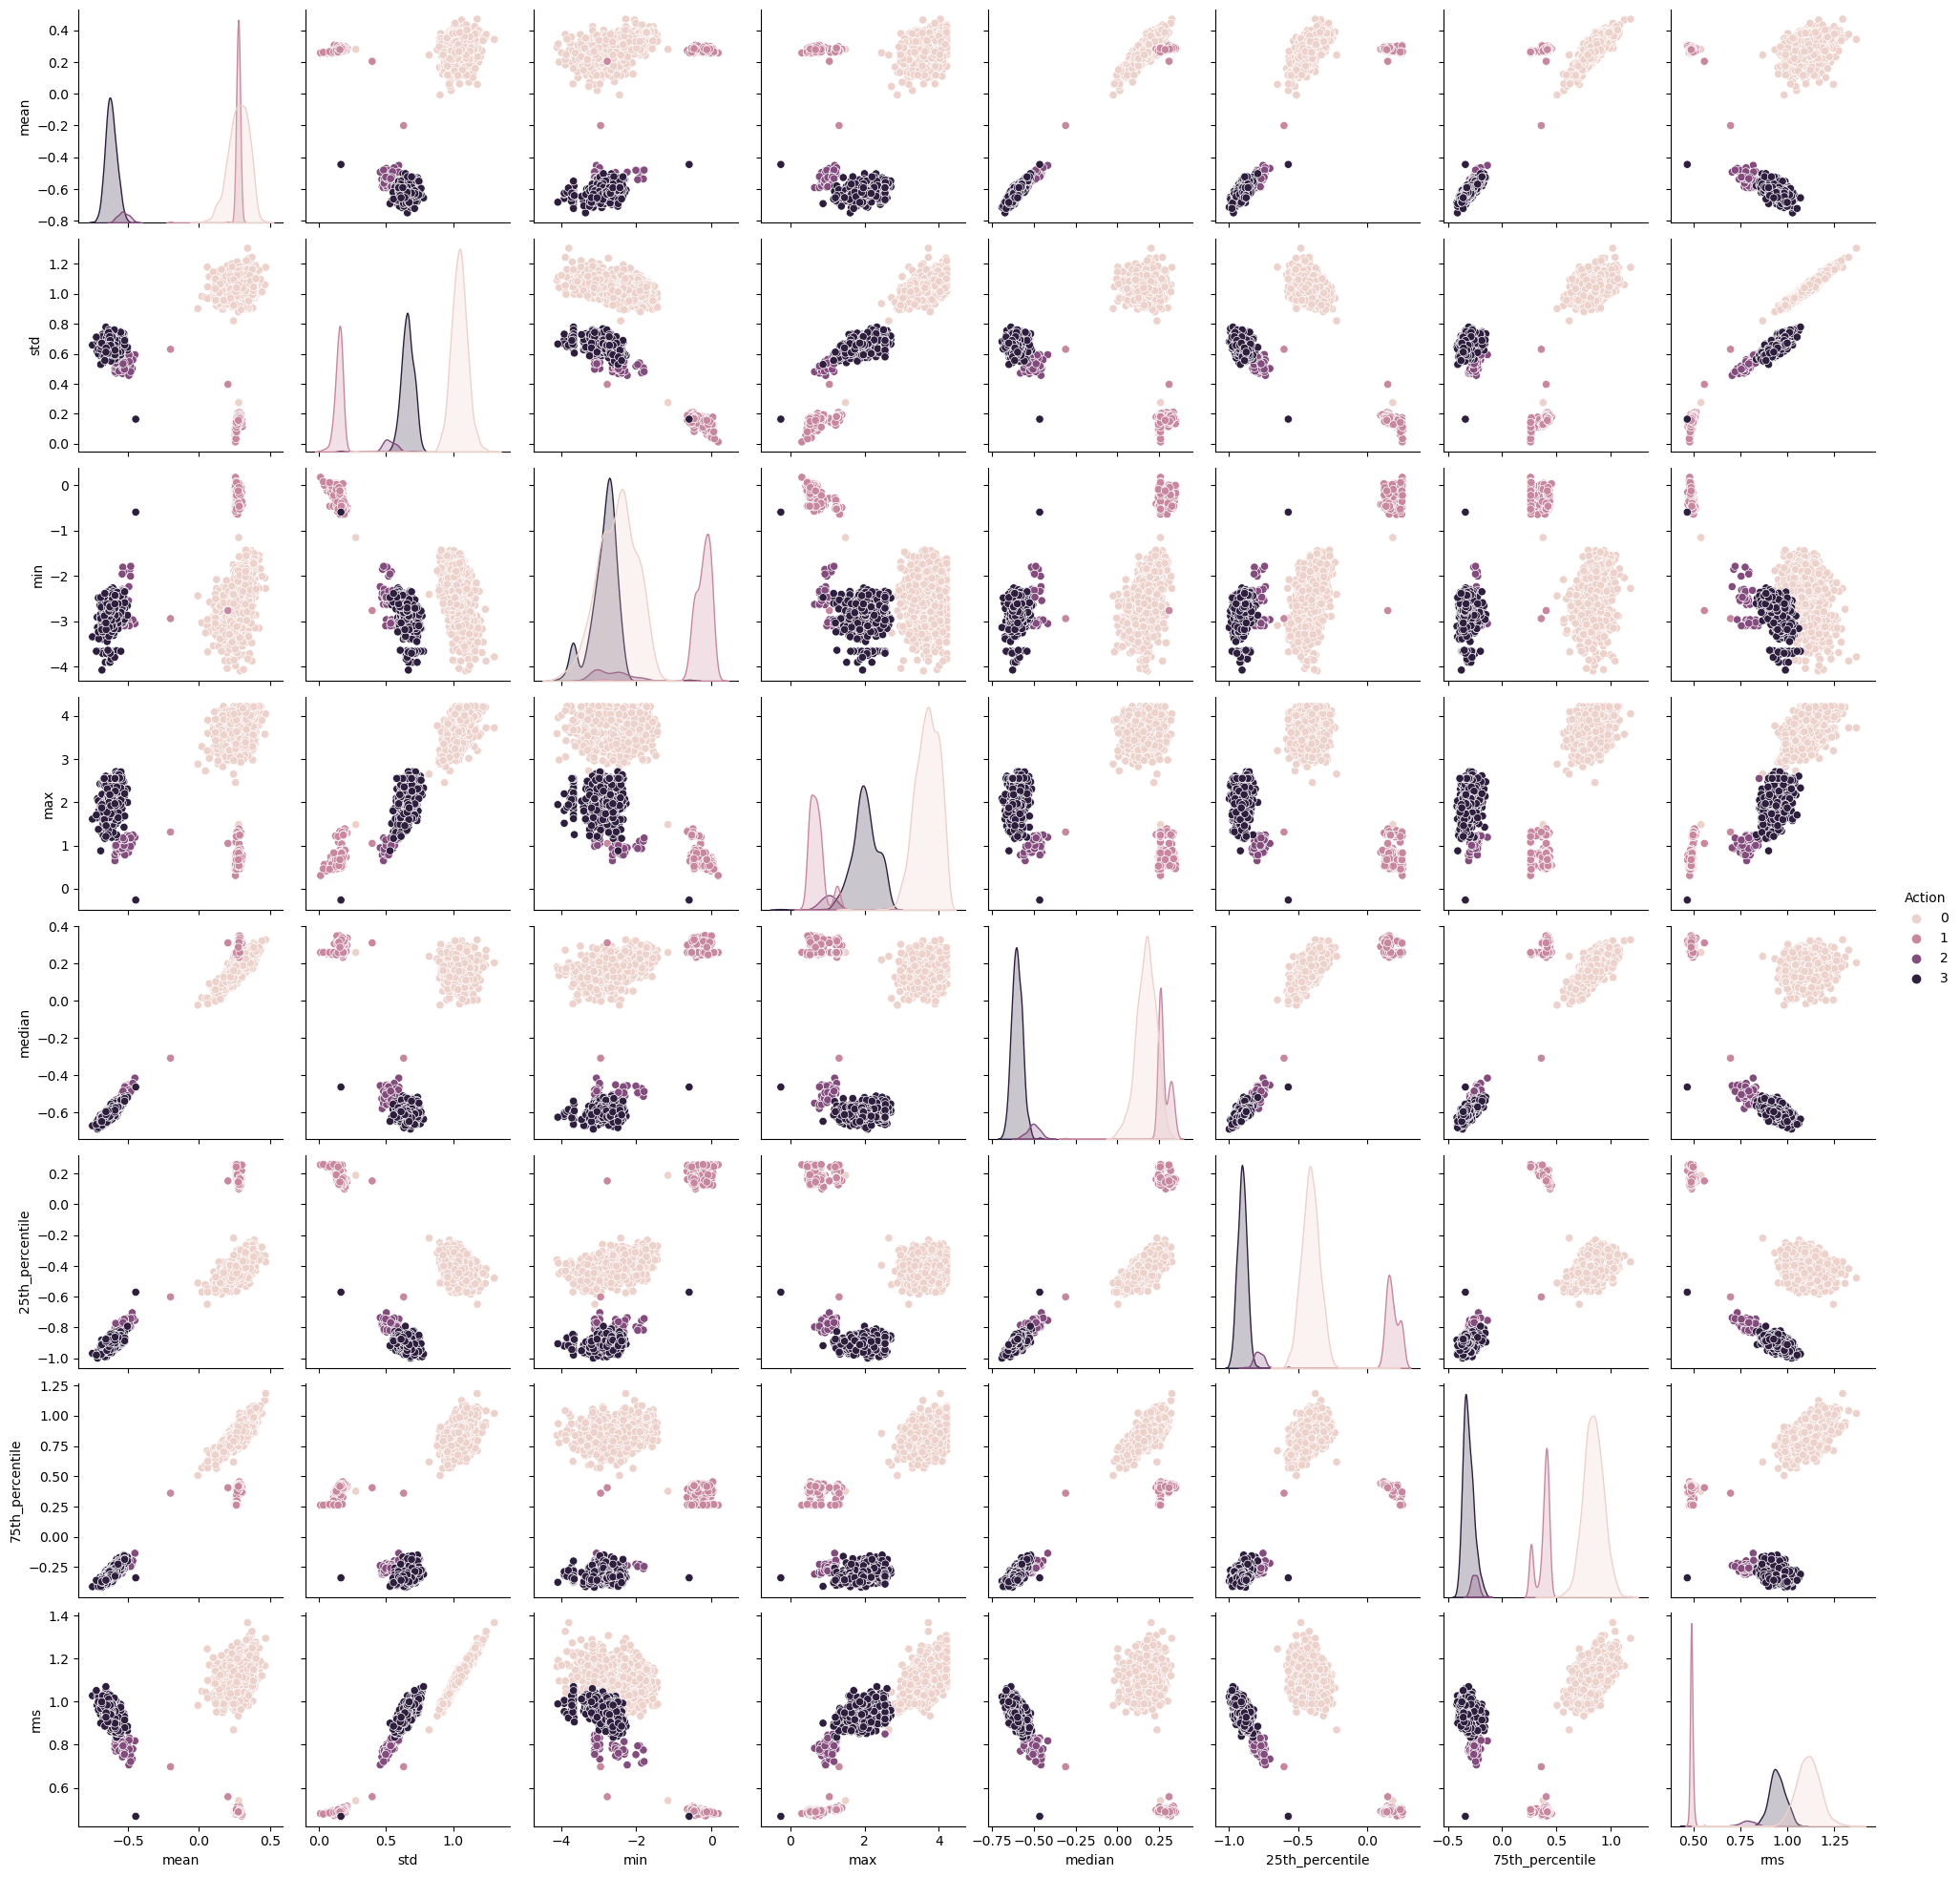

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Виберемо підмножину узагальнених ознак для візуалізації
generalized_features_subset = time_domain_df[['mean', 'std', 'min', 'max', 'median', '25th_percentile', '75th_percentile', 'rms', 'Action']]

# Використаємо бібліотеку seaborn для побудови графіків розсіювання
sns.pairplot(generalized_features_subset, hue='Action')
plt.show()

    Видно, що дані чудово групуються.
    Щоб спробувати візуально оцінити змінні, що найбільш відрізняються між собою для окремих наборів даних, зобразимо графіки залежності їх значень від сегменту

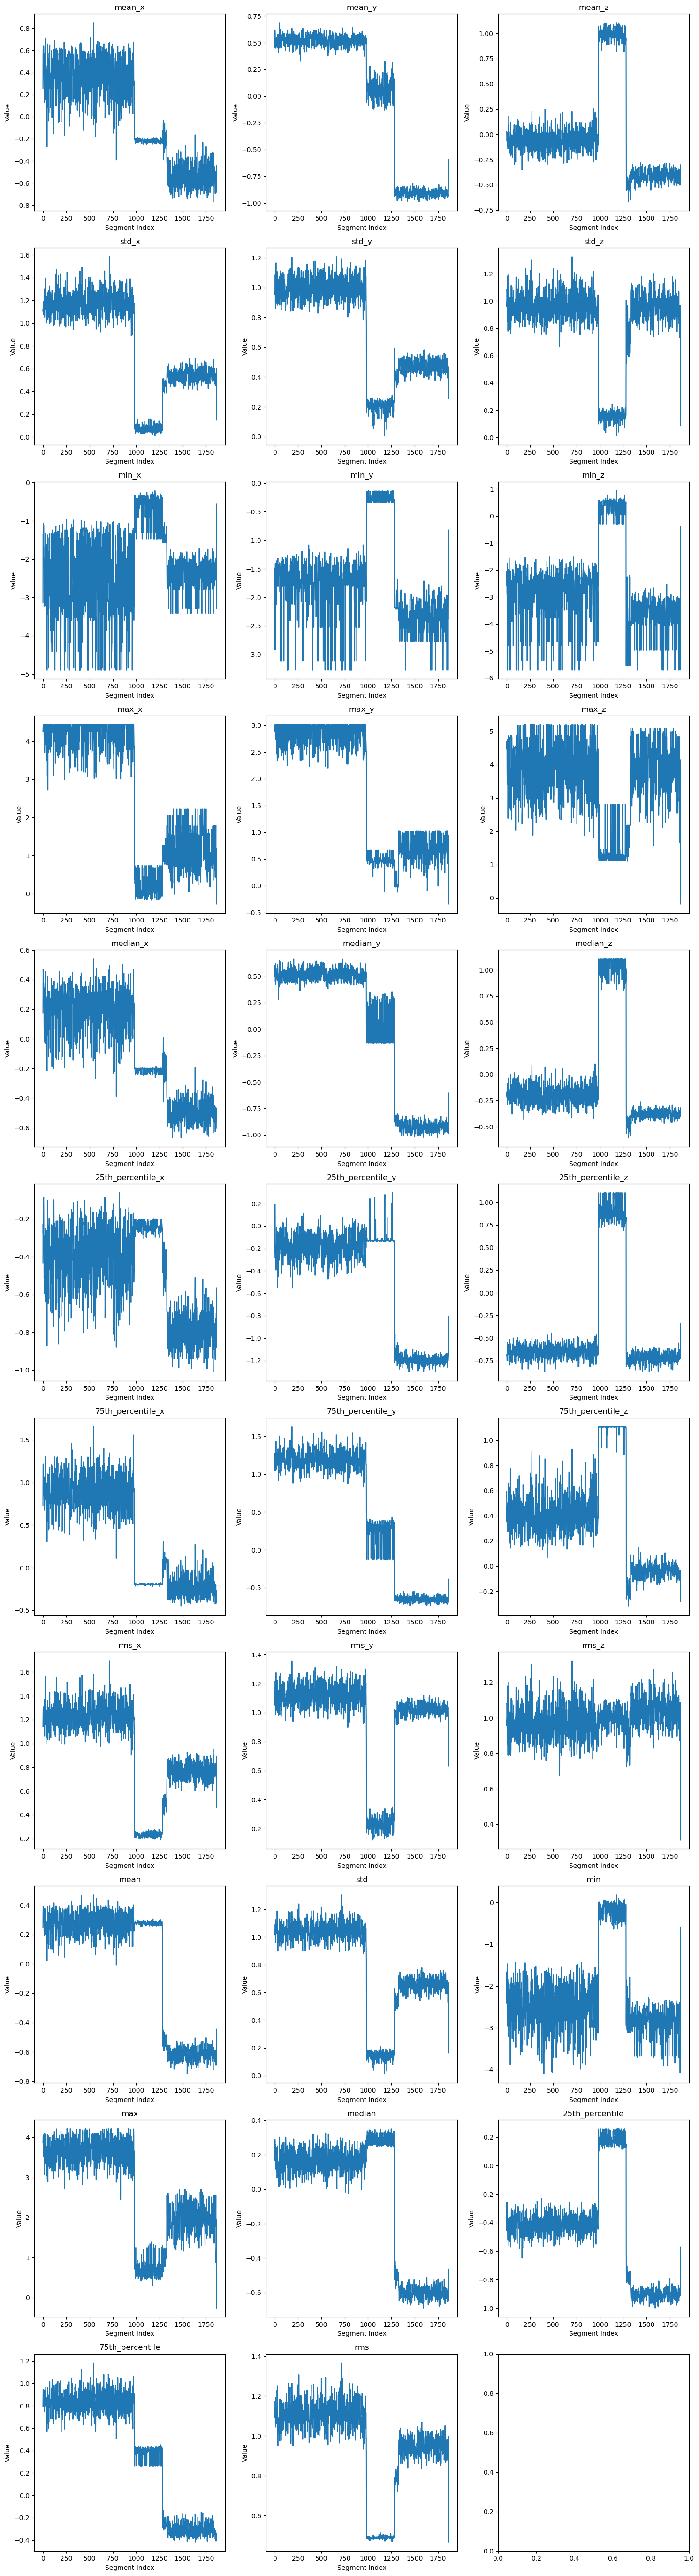

In [101]:
import matplotlib.pyplot as plt

num_features = len(time_domain_df.columns) - 1  # Мінус 1 для виключення стовпця 'Action'
num_rows = num_features // 3
if num_features % 3 != 0:
    num_rows += 1

fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
feature_idx = 0

for i in range(num_rows):
    for j in range(3):
        if feature_idx < num_features:
            feature_name = time_domain_df.columns[feature_idx]
            axs[i, j].plot(time_domain_df.index, time_domain_df[feature_name])
            axs[i, j].set_title(feature_name)
            axs[i, j].set_xlabel('Segment Index')
            axs[i, j].set_ylabel('Value')
            feature_idx += 1
        else:
            break
plt.tight_layout()
plt.show()




    Серед всіх графіків наглядним є різниця в значеннях rms_x.
    Дана часова характеристика дозволяє найбільш якісно виділити невелику групу даних, отриманих з акселерометра під час ходьби по сходах.
    Хоча в сукупності всі дані дозволяють максимально ефективно розділити вибірки, проте слід виділити деякі, щоб спростити алгоритм.

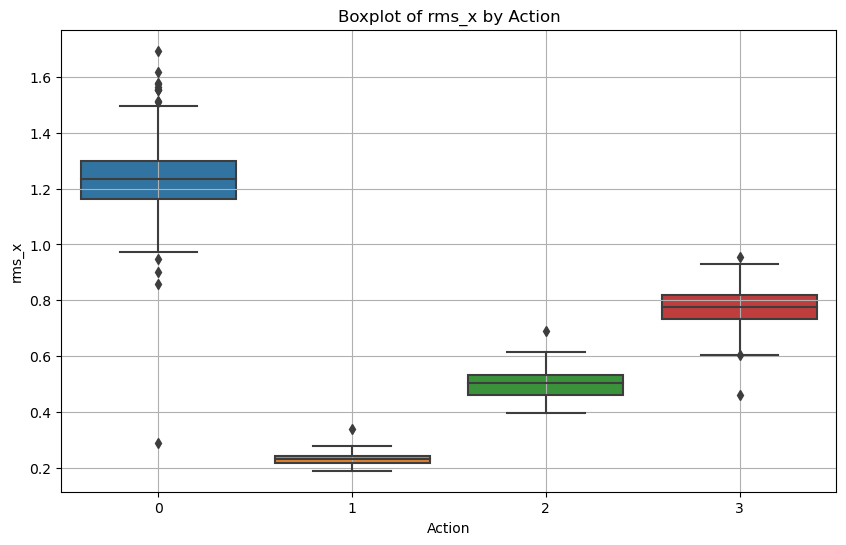

In [102]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Action', y='rms_x', data=time_domain_df)
plt.title('Boxplot of rms_x by Action')
plt.xlabel('Action')
plt.ylabel('rms_x')
plt.grid(True)
plt.show()


    Очевидно, що навіть з одним лише значенням rms_x можна розділити дані.
    Далі перевіримо це повторивши навчання моделей random_forest i SVM за даним параметром

In [103]:
# Вибираємо дані для навчання та тестування
X = time_domain_df[['rms_x']]
y = time_domain_df['Action']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# класифікатор SVM
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("Точність моделі SVM:", svm_accuracy)
svm_report = classification_report(y_test, svm_predictions)
print("Classification Report for SVM:\n", svm_report)


# класифікатор випадкового лісу
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Точність моделі випадкового лісу:", rf_accuracy)


Точність моделі SVM: 1.0
Classification Report for SVM:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00       101

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373

Точність моделі випадкового лісу: 0.9973190348525469


    Далі оцінимо по кожній з характеристик окремо

In [104]:
def svm_rf_classifiers(X_train, X_test, y_train, y_test, features):
    results = pd.DataFrame(columns=['Feature', 'SVM Accuracy', 'RF Accuracy'])
    
    for feature in features:
        # SVM classifier
        svm_classifier = SVC()
        svm_classifier.fit(X_train[[feature]], y_train)
        svm_predictions = svm_classifier.predict(X_test[[feature]])
        svm_accuracy = accuracy_score(y_test, svm_predictions)
        
        # Random Forest classifier
        rf_classifier = RandomForestClassifier()
        rf_classifier.fit(X_train[[feature]], y_train)
        rf_predictions = rf_classifier.predict(X_test[[feature]])
        rf_accuracy = accuracy_score(y_test, rf_predictions)
        
        results = pd.concat([results, pd.DataFrame({'Feature': feature, 'SVM Accuracy': svm_accuracy, 'RF Accuracy': rf_accuracy}, index=[0])], ignore_index=True)

    # Sort results by accuracy in descending order
    results = results.sort_values(by=['SVM Accuracy', 'RF Accuracy'], ascending=False)
    
    return results

# Вибір дані для навчання та тестування
X = time_domain_df.drop('Action', axis=1)  # Всі ознаки, крім цільової
y = time_domain_df['Action']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Отримання списку функцій
features = X.columns.tolist()

# Виклик функції та виведення результатів
results = svm_rf_classifiers(X_train, X_test, y_train, y_test, features)
print(results)


              Feature  SVM Accuracy  RF Accuracy
21              rms_x      1.000000     0.997319
29    25th_percentile      0.989276     0.994638
25                std      0.983914     0.981233
20  75th_percentile_z      0.975871     0.978552
3               std_x      0.965147     0.973190
4               std_y      0.965147     0.962466
13           median_y      0.965147     0.962466
19  75th_percentile_y      0.965147     0.957105
2              mean_z      0.965147     0.949062
1              mean_y      0.965147     0.946381
30    75th_percentile      0.962466     0.946381
31                rms      0.962466     0.935657
0              mean_x      0.957105     0.959786
12           median_x      0.957105     0.959786
27                max      0.954424     0.973190
14           median_z      0.927614     0.935657
10              max_y      0.922252     0.986595
9               max_x      0.903485     0.975871
7               min_y      0.879357     0.989276
28             media

        Отримані результати свідчать про те, що було вірно обрано ознаку для навчання моделі.
        Далі модель можна посилити, обравши додаткові ознаки - 25th_percentile і std

In [105]:
# Вибираємо дані для навчання та тестування
X = time_domain_df[['rms_x', '25th_percentile', 'std']]
y = time_domain_df['Action']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# класифікатор SVM
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("Точність моделі SVM:", svm_accuracy)
svm_report = classification_report(y_test, svm_predictions)
print("Classification Report for SVM:\n", svm_report)


# класифікатор випадкового лісу
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Точність моделі випадкового лісу:", rf_accuracy)


Точність моделі SVM: 0.9973190348525469
Classification Report for SVM:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       205
           1       1.00      1.00      1.00        54
           2       1.00      0.92      0.96        13
           3       0.99      1.00      1.00       101

    accuracy                           1.00       373
   macro avg       1.00      0.98      0.99       373
weighted avg       1.00      1.00      1.00       373

Точність моделі випадкового лісу: 1.0


    Алгоритм SVM дещо знизив точність, а випадкового лісу - підвищив.
    Далі - розділення даних на основі трьох характеристик.

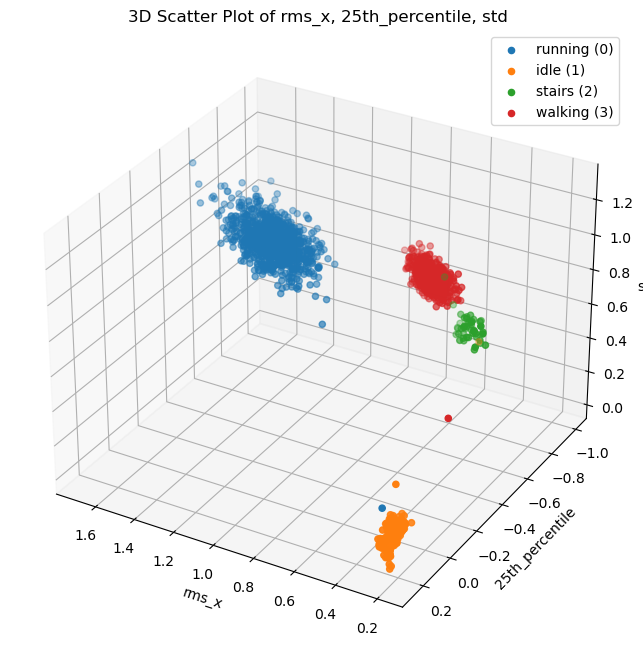

In [106]:
from mpl_toolkits.mplot3d import Axes3D

features_subset = time_domain_df[['rms_x', '25th_percentile', 'std', 'Action']]
class_labels = features_subset['Action'].unique()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in class_labels:
    class_data = features_subset[features_subset['Action'] == label]
    ax.scatter(class_data['rms_x'], class_data['25th_percentile'], class_data['std'], label=f'Action {label}')

ax.set_xlabel('rms_x')
ax.set_ylabel('25th_percentile')
ax.set_zlabel('std')
ax.set_title('3D Scatter Plot of rms_x, 25th_percentile, std')
ax.legend()

ax.view_init(elev=30, azim=120)

actions_legend = {0: 'running', 1: 'idle', 2: 'stairs', 3: 'walking'}
handles, labels = ax.get_legend_handles_labels()
updated_labels = [f"{actions_legend[int(label.split(' ')[-1])]} ({int(label.split(' ')[-1])})" for label in labels]
ax.legend(handles, updated_labels)

plt.show()

<span style="font-size:18px; color:green;">Висновок:</span><br>
<span style="font-size:18px; color:green;">За допомогою розділення даних на групи по 208 із перекриттям послідовних груп на 50% було виокремлено ряд ознак у time_domain_df, а саме:<br><span style="font-weight:bold; color:red;">'mean_x', 'mean_y', 'mean_z', 'std_x', 'std_y', 'std_z', 'min_x', 'min_y', 'min_z', 'max_x', 'max_y', 'max_z', 'median_x', 'median_y', 'median_z', '25th_percentile_x', '25th_percentile_y', '25th_percentile_z', '75th_percentile_x', '75th_percentile_y', '75th_percentile_z', 'rms_x', 'rms_y', 'rms_z', 'mean', 'std', 'min', 'max', 'median', '25th_percentile', '75th_percentile', 'rms', 'Action'</span></span><br>
<br>
<span style="font-size:18px; color:green;">Серед цих ознак обрано 3 з найкращим розділенням при навчанні - <span style="font-weight:bold; color:red;">'rms_x', '25th_percentile', 'std'</span>.</span><br>
<br>
<span style="font-size:18px; color:green;">Проте слід зауважити, що навіть єдина часова змінна - <span style="font-weight:bold; color:red;">'rms_x'</span>, дозволяє отримати максимальне розділення алгоритмами SVM та випадковий ліс з бібліотеки scikit-learn.</span>


    Слід зазначити, що при скороченні числа "segment_size", значно зростає час на обробку масиву даних, навіть зі скороченим числом часових ознак. Також значно знижується точність алгоритмів для окремих ознак.
    Таким чином можна стверджувати про оптимальні параметри кількості семплів а також 50%-ве перекриття при розрахунку часових ознак.


        PS.
    Обрана характеристика - rms - корінь квадратний з середнього квадрату - це статистична міра, яка використовується для оцінки амплітуди значень змінної. У контексті аналізу сигналів і часових рядів, таких як прискорення або звукові хвилі, RMS використовується для вимірювання рівня сигналу, який може бути визначений як середньоквадратичне значення амплітуди сигналу.

    Ця міра дозволяє отримати числове значення, яке представляє розмір або енергію сигналу, а також використовується для порівняння інтенсивності сигналів. У нашому випадку, ознака "rms_x" відображає значення RMS для вісі "x" сигналу прискорення.